In [4]:
import torch
import math
from SC_IPFP.torch.utils import NN, log_kde_pdf_per_point, silvermans_rule
from SC_IPFP.torch.sde_solvers_time import solve_sde_RK


from tqdm.notebook import tqdm

from torch import nn

import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt

In [5]:
from torch import nn
class NN(nn.Module):

    def __init__(self, input_dim=1,  weight_dim_list=[20,20,20]):
        super(NN, self).__init__()

        self.weight_dim_list = [input_dim] + weight_dim_list
        self.layers = [None for i in weight_dim_list]

        for i in range(len(weight_dim_list)):
            setattr(
                self,
                "f" + str(i),
                nn.Linear(
                    self.weight_dim_list[i], self.weight_dim_list[i + 1],
                    bias=True
                )
            )
            self.layers[i]  = getattr(self, "f" + str(i))

            torch.nn.init.xavier_uniform(self.layers[i].weight)
    
    def get_var(self , other=None):
        return torch.tensor([[0]]).double()

    def forward(self, x, var=None):
        functerino = torch.tanh
        x_ = x.clone()
        for i_, layer in enumerate(self.layers[:-1]):
            try:
                x = functerino(layer(x))
            except:
                print(x.shape, i_, x_.shape)
                import pdb; pdb.set_trace()
                raise
        try:
            return (self.layers[-1](x))
        except:
            import pdb; pdb.set_trace()
            raise


In [6]:
def solve_sde_RK(alfa=None, beta=None, X0=None, dt=1.0, N=100, t0=0.0,
                theta=None, noise=False, forwards=True):
    """
            Euler Mayurama method
    Syntax:
    ----------
    solve_sde(alfa=None, beta=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        alfa  : a  function with two arguments, the X state and the time
                defines the differential equation.
        beta  : a  function with two arguments, the X state and the time
                defines the stochastic part of the SDE.
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)
    
    """
    
#     print(X0)
       
    if alfa is None or beta is None:
        raise ValueError("Error: SDE not defined.")

    n, d, *_ = X0.shape
    
    T = torch.tensor(dt * N).cuda()
    
    DWs  = torch.empty((n, N-1, d)).normal_(mean=0, std=1).cuda() * math.sqrt(dt)
    
    
    Y, ti = torch.zeros((n, N, d + 1)).double().cuda(), torch.arange(N).double().cuda()*dt + t0
    t0rep =  (
        t0 * torch.ones((X0.shape[0], 1)).double().cuda() if forwards
        else (T-t0) * torch.ones((X0.shape[0], 1)).double().cuda()
    )
#     Y[:, 0, :] =  torch.cat((X0, t0rep), axis=1 )
    Y = torch.cat((X0, t0rep), axis=1 )[:, None, :]

    N = int(N)
    
    T = dt * N
        
    for n in range(N-1):
        t = ti[n]
        a, DW_n = alfa(Y[:,n, :]),  DWs[:,n,:]
        newY = (  
            Y[:,n, :-1] + a * dt + beta * DW_n
        )
        
        trep = (
            t.repeat(newY.shape[0]).reshape(-1,1) if forwards
            else T - t.repeat(newY.shape[0]).reshape(-1,1)
        )
        
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]
        Y = torch.cat((Y,tocat) , dim=1)
    if torch.isnan(Y).any() or torch.isinf(Y).any(): import pdb; pdb.set_trace()
#     import pdb; pdb.set_trace()
    return ti, Y

In [7]:
def divergence(outputs, inputs):
    grads_ = torch.autograd.grad(
            outputs, inputs, torch.ones_like(outputs),
            retain_graph=True, create_graph=True
     )[0]
    return grads_[:,:,:-1].sum(dim=2)

In [8]:
from copy import deepcopy
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = None, rng_b = None, 
                nrng = None, number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, weight_decay = 0.9, create_network=None,
                log_prob=log_kde_pdf_per_point, optimizer=torch.optim.SGD, lrs = None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        with torch.cuda.device(0):
        
            self.X_0 = X_0.requires_grad_()
            self.X_1 = X_1.requires_grad_()

            self.H_0 = silvermans_rule(X_0)
            self.H_1 = silvermans_rule(X_1)

            _, self.dim = self.X_0.shape

            weights = weights + [self.dim]


            self.b_forward = NN(self.dim + 1, weights).double().cuda()
            self.b_backward = NN(self.dim + 1, weights).double().cuda()

            self.theta_f = list(self.b_forward.parameters())
            self.theta_b = list(self.b_backward.parameters())

            self.sigma = sigma_sq

            self.optimizer_f = optimizer(
                self.theta_f, lr=step_size, weight_decay=weight_decay
            )

            self.optimizer_b = optimizer(
                self.theta_b, lr=step_size, weight_decay=weight_decay
            )
            
            m = 0.1
            lr_lambda = lambda epoch : 1.0 / (1.0 + lrs * epoch)


            self.lrs_f  = torch.optim.lr_scheduler.LambdaLR(self.optimizer_f, lr_lambda, last_epoch=-1)
            self.lrs_b  = torch.optim.lr_scheduler.LambdaLR(self.optimizer_b, lr_lambda, last_epoch=-1)

            num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
            self.num_batches_f = num_complete_batches_f + bool(leftover_f)

            num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
            self.num_batches_b = num_complete_batches_b + bool(leftover_b)

            self.first_iter_fac = 0.0

            self.log_prob = log_prob

            self.burn_in = False
    
    def data_stream(self, forward=True):
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = torch.randperm(X.size()[0])
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
    def loss_for_trajectory(self, Xt, forwards):
        n_, *_ = Xt.shape
        
#         if not forwards :
#             Xt = Xt.flip(1)
        
        if forwards:
            b_minus  = self.b_backward.forward( Xt)
            b_plus = self.b_forward.forward(Xt)
            div = divergence(b_minus, Xt)
        else:
            b_minus  = self.b_backward.forward(Xt)
            b_plus = self.b_forward.forward(Xt) * self.first_iter_fac 
            div = -divergence(b_plus, Xt) * self.first_iter_fac 

            
        sign = 1.0 if forwards else -1.0
        
        time_integral = (sign *  (b_plus - b_minus))**2 * self.dt 
        out =  0.5 * time_integral.sum(dim=(1,2))  - (div.sum(dim=(1)) *  self.dt )
        
        return out


    def inner_loss_jit(self, batch,  
                       batch_terminal_empirical,
                       forwards):
        
        b = (
            self.b_forward.forward
            if forwards else (lambda X: -self.b_backward.forward(X))
        )
        
        t, Xt, *W = self.sde_solver(
            b, self.sigma, batch, self.dt, 
            self.number_time_steps, 0,
            None, False, forwards
        )
        Ht = silvermans_rule(Xt[:,-1,:-1])
        H = silvermans_rule(batch_terminal_empirical)
        
        main_term = self.loss_for_trajectory(Xt, forwards)

        if not self.burn_in:
#             xx = torch.linspace(-30, 30 , 1000).reshape(-1,1).double().cuda()
#             yy = self.log_prob( xx, batch_terminal_empirical, H)  
#             plt.plot(
#                 xx.detach().cpu().numpy(),
#                 np.exp(yy.detach().cpu().numpy())
#             )
#             plt.show()
            cross_entropy = -self.log_prob( Xt[:,-1,:-1], batch_terminal_empirical, H)             
        else:
            cross_entropy = -self.log_prob(batch_terminal_empirical, Xt[:,-1,:-1], Ht)

        J = torch.mean(main_term +  2.0 * cross_entropy )
        J = torch.squeeze(J)
        return J
    
    def inner_loss(self, batch, forwards=True):
        
        if self. burn_in:
            self.batch_terminal_empirical_burn = next(self.data_stream(forward=forwards))
            self.H_burn = self.H_0 if forwards else self.H_1
#         else:
        batch_terminal_empirical = next(self.data_stream(forward=not(forwards)))
        H = self.H_1 if forwards else self.H_0

        return self.inner_loss_jit(
            batch, batch_terminal_empirical,
            forwards
        )

    def closure(self, X, forwards=True):
        """
        Close method required for pytorches CG and LBFGS optimizers
        :params X[torch.tensor]: nxdim  torch tensor representing dataset
        """
        
        opt = self.optimizer_f if forwards else self.optimizer_b
        
        opt.zero_grad()
        loss = self.inner_loss(X, forwards)
        loss.backward()
        return loss
    
    
    def fit(self, IPFP_iterations=10, sub_iterations=10, plot=False, burn_iterations=7):     
        
        name = str(self.optimizer_f).lower()
        bfgs_cg_flag  = "bfgs" in name or "cg" in name
        close_f, close_b =  [], []

        
        
        if plot: self.plot_trajectories()
        
        self.first_iter_fac = 0.0
        if burn_iterations > 0 : self.burn_in = True
            
        self.b_thetas , self.f_thetas = [], []
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_b, loss_f = [], []
        for i in tqdm(range(IPFP_iterations + burn_iterations)):
            
            if i == burn_iterations:
                self.burn_in = False
                self.first_iter_fac = 0.0
            
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
                    batch_b =  next(batches_b)
                    
                    if bfgs_cg_flag:
                        close_b = [lambda : self.closure(batch_b, False)]
                    lossb = self.inner_loss(
                        batch_b, False
                    )
                    lossb.backward()
                    self.optimizer_b.step(*close_b)
                    self.lrs_b.step()
                print(f"loss b {lossb}")
                
            loss_b.append(lossb)
            self.b_thetas.append(deepcopy(self.theta_b))

            self.first_iter_fac = 1.0
       
            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
                    batch_f =  next(batches_f)
                    if bfgs_cg_flag:
                        close_f = [lambda : self.closure(batch_f, True)]
                    lossf = self.inner_loss(
                        batch_f, True
                    )
                    
                    lossf.backward()
                    self.optimizer_f.step(*close_f)
                    self.lrs_f.step()
  
                print(f"loss f {lossf}")
            
            loss_f.append(lossf)
            self.f_thetas.append(deepcopy(self.theta_f))

            self.loss_f = loss_f
            self.loss_b = loss_b
            if plot: self.plot_trajectories()

        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
        
    def plot_trajectories(self):
        bb = lambda X: -self.b_backward(X)

        t, Xts = self.sde_solver(
            self.b_forward.forward, self.sigma,
            self.X_0, self.dt,  self.number_time_steps, 0.0,
            self.theta_f, False, True
        )
        t_, Xts_ = self.sde_solver(
            bb, self.sigma, 
            self.X_1, self.dt, self.number_time_steps, 0.0, 
            self.theta_b, False, False
        )
        
        fn = 14
        fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
        axs[1].set_xlabel("$t$", fontsize=fn)
        axs[1].set_ylabel("$x(t)$", fontsize=fn)
        axs[0].set_ylabel("$x(t)$", fontsize=fn)

        tt = axs[1].get_xticks()
        axs[1].set_xticks(tt.flatten() )
        axs[1].set_xticklabels(list(map (lambda x: '{0:.2f}'.format((x)), tt))[::-1])

        for i in range(n):
            label = "$\mathbb{Q}$: Forward process" if i == 0 else None
            axs[0].plot(t.cpu().flatten(), Xts[i,:,:-1].detach().cpu().numpy().flatten(), 'b', alpha=0.03,  label=label)


        for i in range(n):
            label = "$\mathbb{P}$: Reverse process" if i == 0 else None
            axs[1].plot(t_.cpu().flatten(), Xts_[i,:, :-1].detach().cpu().numpy().flatten(), 'r', alpha=0.03, label=label)

        axs[1].legend(fontsize=fn)
        axs[0].legend(fontsize=fn)

        plt.show()    
    
    #     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
            

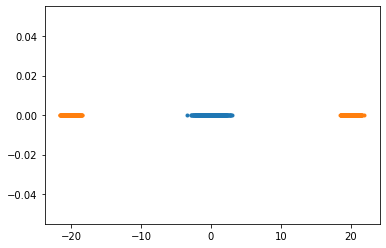

In [9]:
import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n = 900
n_2 = int(n * 1.0 / 3)
n_2 = int(n * 1.0 / 2.0)


X1 = npr.randn(n).reshape(-1,1) - 0
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 20
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) -20
# X23 =  0.6 * npr.randn(n_2).reshape(-1,1) + 20

X2 = np.concatenate((X21, X22), axis=0)
X1, X2 = X2, X1

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

with torch.cuda.device(0):

    X1 = torch.tensor(X1).cuda()
    X2 = torch.tensor(X2).cuda()

In [12]:


torch.cuda.manual_seed_all(10)
torch.manual_seed(10)

c = cIPFP(
    X1, X2,  number_time_steps=100, batch_size=900 ,
    step_size=1e-2, weights=[20, 20, 20], rng = None,
    optimizer=torch.optim.Adam, lrs = 0.09, weight_decay=0, sigma_sq=2
)

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


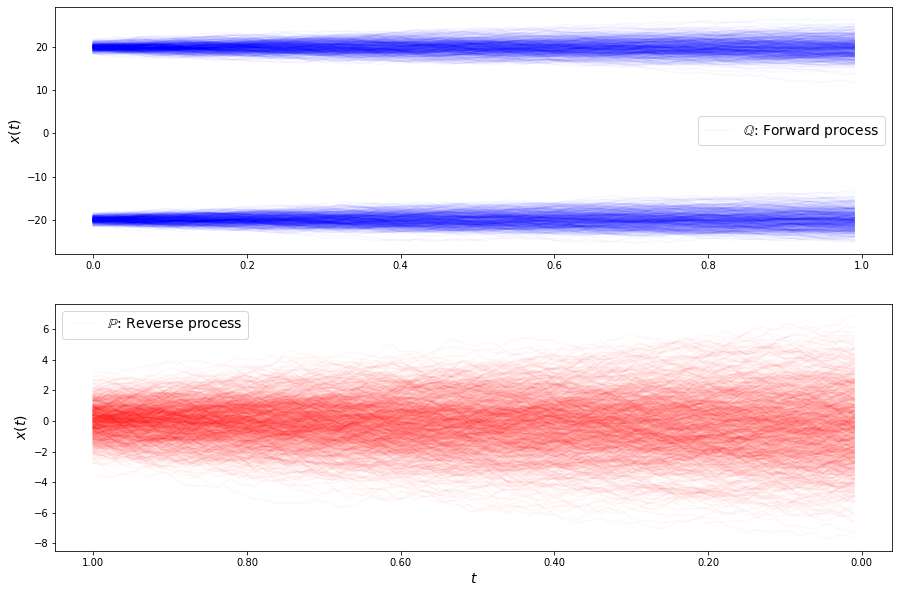

loss b 542.7887944204516
loss b 393.7806156211084
loss b 368.11737890899275
loss b 202.27948238647087
loss b 268.9128145839016
loss b 221.64801817653526
loss b 234.43355336307465
loss b 210.50778688267854
loss b 161.33321452931773
loss b 170.14936766628944
loss b 157.2860485203339
loss b 147.27839887101607
loss b 98.12159762751814
loss b 140.82876753473255
loss b 123.54464064916353
loss b 150.7717285685825
loss b 119.89728713965111
loss b 132.72260572730858
loss b 100.85173155135519
loss b 110.27728383208797
loss b 84.41074184755885
loss b 107.67397671532873
loss b 107.20096955085866
loss b 85.24867863667357
loss b 96.71931880106338
loss b 95.65683209553009
loss b 97.22150027593564
loss b 94.15866686423225
loss b 83.01536102259554
loss b 91.08819109655526
loss f 90.45037457790073
loss f 76.08608756922322
loss f 65.50135146581987
loss f 67.21286707952278
loss f 55.75583973446002
loss f 56.56851815632104
loss f 58.2966800699775
loss f 40.30210098532593
loss f 43.560903771972825
loss f 49

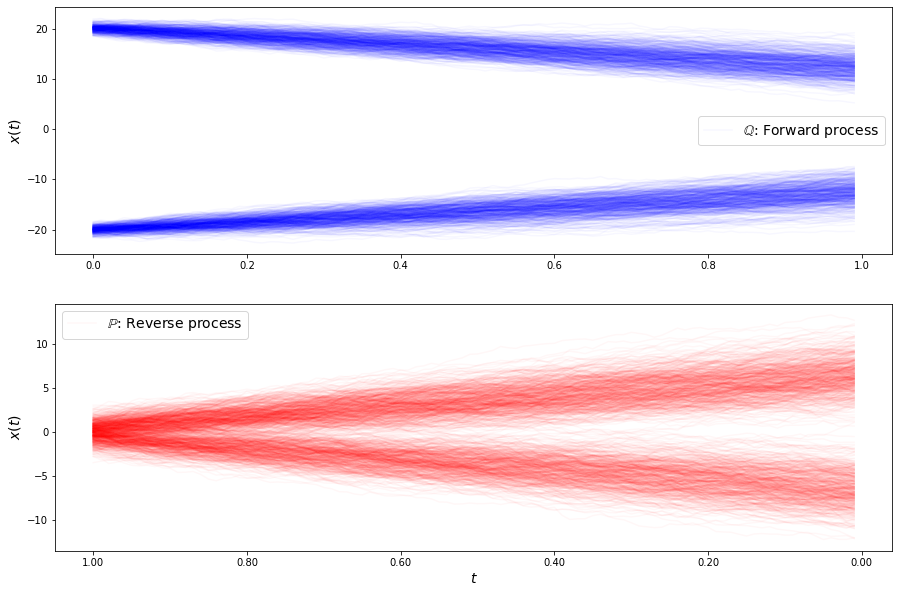

loss b 65.19902910846257
loss b 54.600424655498905
loss b 69.46461582984777
loss b 82.83035614111914
loss b 62.35890420351484
loss b 73.49674464021473
loss b 56.78242566093072
loss b 59.07539304647046
loss b 76.24531027854756
loss b 52.42057333518615
loss b 70.9362225615814
loss b 48.29761725157922
loss b 50.4289750875863
loss b 54.08824404952275
loss b 61.698388486285666
loss b 54.914010999718585
loss b 48.05475088670008
loss b 50.323688163740435
loss b 52.50920919835373
loss b 40.712442060065754
loss b 56.110602507637225
loss b 45.109391267003616
loss b 51.137011100114464
loss b 35.71339604344949
loss b 32.09531849571067
loss b 41.82706174531685
loss b 50.75989987780726
loss b 41.4374862097065
loss b 36.94450073997535
loss b 50.30202232806952
loss f 33.56280209913592
loss f 30.88872227397386
loss f 36.48229726367926
loss f 28.794937196844632
loss f 28.014391944767926
loss f 26.49844846883444
loss f 30.54296830013669
loss f 30.268621266701036
loss f 24.112600944051646
loss f 32.573760

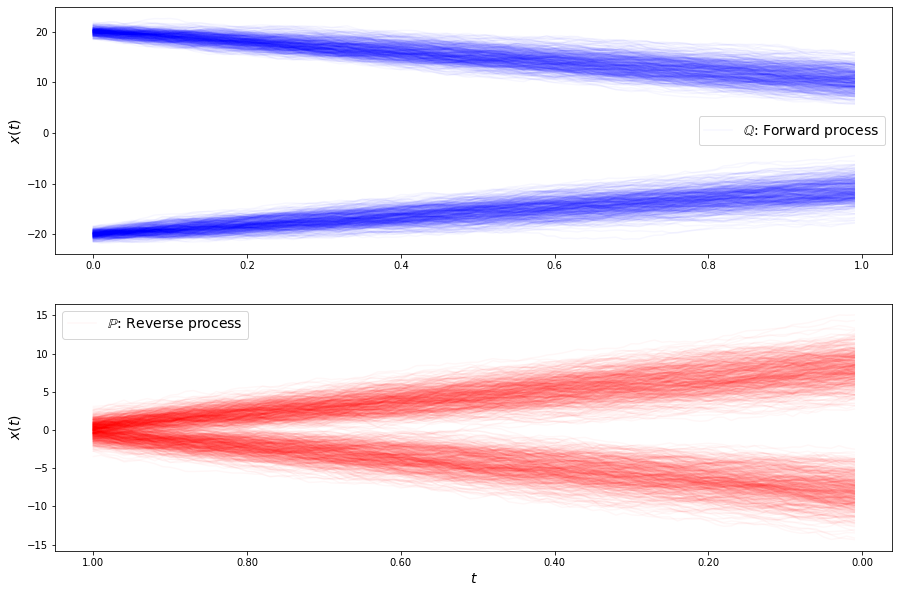

loss b 76.51758962593014
loss b 77.23312115399006
loss b 76.52351892199879
loss b 76.55713880674992
loss b 76.10852308869411
loss b 77.69185985968927
loss b 76.14821674215877
loss b 76.5280397664003
loss b 77.22890468999104
loss b 76.29476807785896
loss b 75.95919854325751
loss b 76.25469098860033
loss b 76.18939385421324
loss b 77.1330077246051
loss b 77.3762110094721
loss b 77.04586509681143
loss b 76.58588838065091
loss b 76.66918664028391
loss b 77.00794323196749
loss b 77.59577427688066
loss b 76.40842087565119
loss b 76.60468901748095
loss b 77.41291105013572
loss b 77.1080997915943
loss b 76.72025291670708
loss b 76.83199287481997
loss b 76.05449430117754
loss b 77.04653864139453
loss b 76.69723804809466
loss b 76.89514042984963


In [ ]:
torch.autograd.set_detect_anomaly(True)
c.fit(200, 30, burn_iterations=2, plot=True)

In [ ]:
plt.plot(c.loss_f[10:])
plt.show()
plt.plot(c.loss_b[10:])

In [17]:
bb = lambda X: -c.b_backward(X)

t, Xts = c.sde_solver(
    c.b_forward.forward, c.sigma,
    c.X_0, c.dt,  c.number_time_steps, 0.0,
    c.theta_f, False, True
)
t_, Xts_ = c.sde_solver(
    bb, c.sigma, 
    c.X_1, c.dt, c.number_time_steps, 0.0, 
    c.theta_b, False, False
)

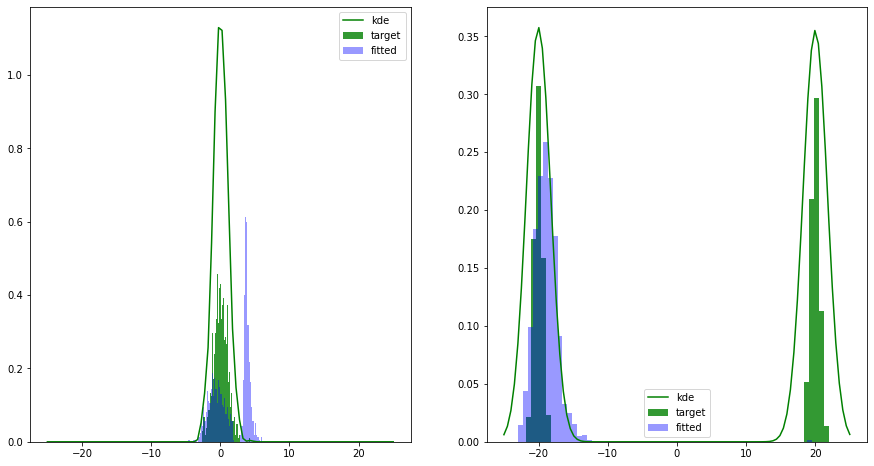

In [18]:
fig, axs = plt.subplots(1,2, figsize=(15, 8))
batch_terminal_empirical_f = next(c.data_stream(forward=True))
xx = torch.linspace(-25, 25).reshape(-1,1).cuda().double()

H = silvermans_rule(batch_terminal_empirical_f)
kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, H).detach().cpu().numpy())
axs[1].plot(xx.detach().cpu().numpy(), kd, label="kde", color="green")


bins = 60
axs[1].hist(( X1.detach().cpu().numpy().flatten()), alpha=0.8, bins=bins, label="target", density=True, color="green");
axs[1].hist(( Xts_[:,-1,:-1].flatten().detach().cpu().numpy()), alpha=0.4, bins=bins, label="fitted", density=True, color="blue");
axs[1].legend()




batch_terminal_empirical_b = next(c.data_stream(forward=False))
# xx = torch.linspace(-10, 10).reshape(-1,1).cuda().double()

Hb = silvermans_rule(batch_terminal_empirical_b)
kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, Hb).detach().cpu().numpy())
axs[0].plot(xx.detach().cpu().numpy(), kd, label="kde", color="green")


bins = 60
axs[0].hist(( X2.detach().cpu().numpy().flatten()), alpha=0.8, bins=bins, label="target", density=True, color="green");
axs[0].hist(( Xts[:,-1,:-1].flatten().detach().cpu().numpy()), alpha=0.4, bins=bins, label="fitted", density=True, color="blue");
axs[0].legend()